# Statistische Analyse

Die Daten des Transport-Flairs kannst du als SQLite-Datenbank herunterladen, dabei handelt es sich immer noch um eine beträchtliche Menge.

Zunächst lädst du die Daten ein:

In [1]:
import pandas as pd

In [2]:
posts = pd.read_csv("transport-all-comments.csv.xz", parse_dates=["created_utc"])

Die Tabelle selbst ist sehr einfach aufgebaut:

|Feld|Typ|
|---|---
|id|text|
|url|text|
|text|text|
|parent_id|text|
|score|integer|
|author|text|
|created_utc|timestamp|

In [3]:
posts.dtypes

id                     object
created_utc    datetime64[ns]
url                    object
parent_id              object
author                 object
score                   int64
text                   object
dtype: object

Bei User Generated Content oder auch anderen Textdaten ist es häufig sinnvoll, die Analyse in zwei unterschiedlichen Domänen durchzuführen.

Du betrachtest zunächst die strukturierten Daten (die *Metadaten*), um zu überprüfen, ob die statistisch signifikant und valide sind.

Anschließend konzentrierst du dich (im nächsten Notebook) auf die unstrukturierten Daten, also die Texte selbst. Dort versuchst du herauszufinden, ob die für uns relevanten Themen abgedeckt werden.

## Gesamtstatistik

Du startest mit der Berechnung einiger Größen, die du später immer wieder benötigen wirst. Diese sind noch nicht zeitabhängig, sondern sollen dir nur einen Eindruck von der Größe der Datenmenge verschaffen.

Als erstes interessiert dich die Gesamtanzahl der Posts:

In [4]:
len(posts)

978104

Das ist eine sehr große Anzahl von Posts, darin enthalten sind allerdings sowohl Initial-Posts als auch Kommentare auf Posts. 

Wenn du nur die Toplevel- oder Initial-Posts betrachten willst, so ist das leicht möglich, weil bei diesen keine `parent_id` gesetzt ist:

In [5]:
top = posts[posts["parent_id"].isna()]
len(top)

99626

Auch diese Anzahl ist absolut groß genug, um daraus statistisch signifikante Aussagen ableiten zu können.

Oftmals haben Foren oder UGC-Sites das Problem, dass die Inhalte zwar in großer Menge zur Verfügung stehen, aber nur von wenigen Autoren geschaffen werden:

In [6]:
posts["author"].nunique()

293416

Auch hier herrscht eine große Vielfalt, was uns in der Analyse sehr hilft. Betrachte außerdem noch die Anazhl der Autoren, die die Toplevel-Posts erstellt haben:

In [7]:
top["author"].nunique()

38480

Im Verhältnis zu der Anzahl der Toplevel-Posts sind das ziemlich viele Autoren, so dass sich auch hier ein breites Meinungsbild ergibt.

Schau dir zuletzt noch die Namen der Autoren an, die auf dem Toplevel am meisten geschrieben haben:

In [8]:
top.groupby("author").count()["id"].sort_values(ascending=False).head(20)

author
[deleted]       20031
Portis403         866
KirillKlip        624
mvea              599
Philo1927         430
iammarksmith      384
Wagamaga          344
ShiekhW           320
spsheridan        297
wewewawa          297
Abscess2          277
jimrosenz         259
Sorin61           256
prMac             248
speckz            234
trot-trot         227
eyadassem         223
sfantu            190
thanhvu12345      180
dhang18           176
Name: id, dtype: int64

Wenn du die Kommentare mit berücksichtigst, sieht es etwas anders aus:

In [9]:
posts.groupby("author").count()["id"].sort_values(ascending=False).head(20)

author
[deleted]          104428
happyscrappy         2598
dnew                 1024
Portis403             867
danielravennest       764
aquarain              645
KirillKlip            624
mvea                  616
chubbysumo            611
fauxgnaws             600
Vik1ng                583
Natanael_L            575
Badfickle             468
Philo1927             433
txstoploss            433
Tech_AllBodies        425
willcode4beer         406
brickmack             403
l4mbch0ps             399
moofunk               385
Name: id, dtype: int64

Interessant! Es scheint eine klare Differenzierung zwischen Autoren zu geben, die Initialposts schreiben und solchen, die hauptsächlich kommentieren.

So oder so kannst du hier erkennen, dass es sehr aktive Autoren gibt. Das ist aber ein übliches Verhältnis bei sozialen Netzwerken, das Phänomen nennt sich [Ein-Prozent-Regel](https://de.wikipedia.org/wiki/Ein-Prozent-Regel_(Internet)).

Bis hierher sieht also alles gut aus, die Grundwerte der Datenmenge passen!

## Zeitentwicklung von Posts und Kommentaren

Ausgehend von der Business-Fragestellung möchtest du versuchen, Trends abzuleiten und vergangene Trends zu verstehen. Das geht allerdings nur, wenn die Daten hinlänglich aktuell sind. Dewegen analysierst du zunächst den zeitlichen Verlauf der Posts.

Dazu verdichtest du die Daten gleich nach Monaten, eine genauere Analyse ist für den langen Zeitraum nicht sinnvoll:

<Axes: title={'center': 'Gesamtposts pro Monat'}, xlabel='created_utc'>

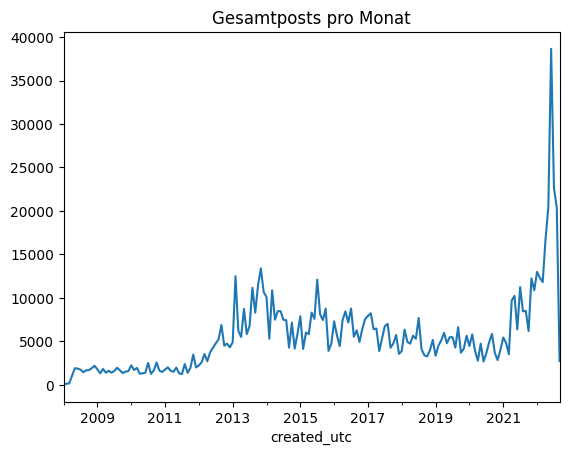

In [10]:
posts.set_index("created_utc").resample("M").count()["id"].plot(title="Gesamtposts pro Monat")

Die Grafik wirkt etwas *unruhig*, weil sich von Monat zu Monat doch größere Änderungen ergeben. Das können wir glätten, indem wir die Posts auf Quartale verdichten. `pandas` bietet uns dazu leistungsfähige Funktionen:

<Axes: title={'center': 'Gesamtposts pro Quartal'}, xlabel='created_utc'>

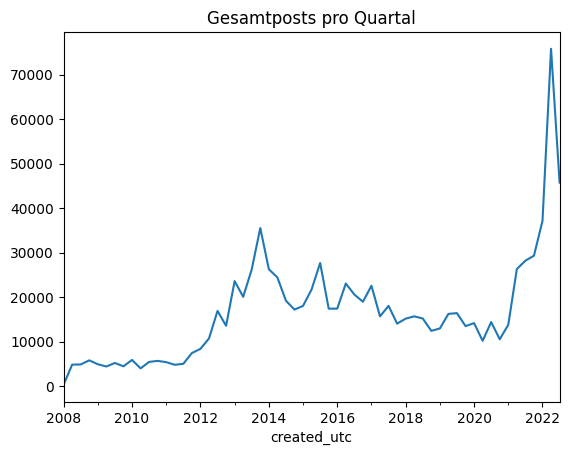

In [11]:
posts.set_index("created_utc").resample("Q").count()["id"].plot(title="Gesamtposts pro Quartal")

Das sieht deutlich übersichtlicher aus. Es ist außerdem ein positiver Trend zu beobachten, was dich zuversichtlich stimmen sollte, dass du statistisch valide Daten analysierst.

Aber Vorsicht, bei den Toplevel-Posts sieht es etwas anders aus:

<Axes: title={'center': 'Toplevel-Posts pro Quartal'}, xlabel='created_utc'>

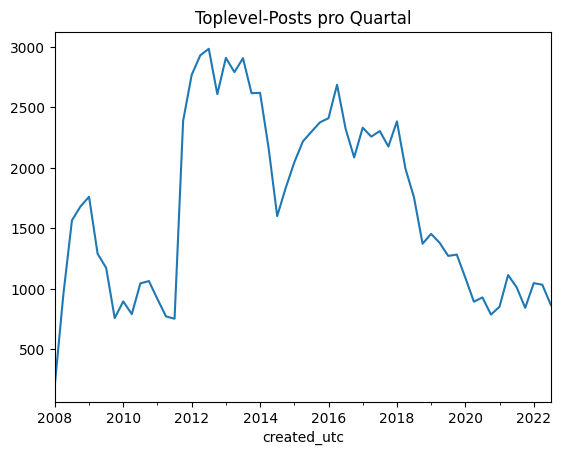

In [12]:
top.set_index("created_utc").resample('Q').count()["id"].plot(title="Toplevel-Posts pro Quartal")

Die Musik spielt hier also in den Kommentaren - sehr spannend und bereits eine wichtige Erkenntnis, die nur aus der Statisitk kommt!

## Statistik über Autoren

Neben den Posts selbst spielen die Autoren eine große Rolle. Wie haben die sich über die Zeit entwickelt? So wäre es etwa ungünstig, wenn es immer weniger Autoren gibt. Auch hier kann dir die Datenbank viel Rechenarbeit abnehmen:

Der Übersichtlichkeit halber aggregierst du das gleich wieder für Quartale:

In [13]:
time_author = posts.set_index("created_utc").resample("Q").agg({"author": pd.Series.nunique })

<Axes: title={'center': 'Autoren pro Quartal'}, xlabel='created_utc'>

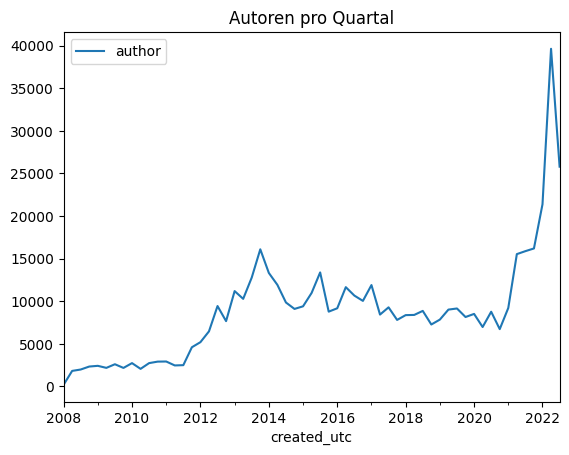

In [14]:
time_author.plot(title="Autoren pro Quartal")

In [ ]:
posts.set_index("created_utc").resample("M").count()["id"].plot(figsize=(16, 9), title="Total posts per month")

Das ist sehr interessant! Offenbar hat die Anzahl der Autoren (inkl. Kommentaren) mit der Zeit ebenso zugenommen, besonders seit 2021. 

Betrachte nun das Posting-Verhalten der Autoren noch etwas genauer und berechne dazu eine Tabelle, in der für jeden Autor die Anzahl der Posts steht:

In [15]:
cpa = posts.groupby("author").count()[["id"]]

Die Posts der gelöschten Accounts interessiert dich nicht (weil sich dahinter vermutlich Einzelposts vieler unterschiedlicher Autoren verbergen). Auch den `AutoModerator` lässt du für die Analyse weg und erzeugst damit einen kleineren `DataFrame`:

In [16]:
cpa = cpa[~cpa.index.isin(["[deleted]", "AutoModerator"])]

Mithilfe der `describe`-Funktion können wir uns statistische Informationen zu der Anzahl der Posts pro Autor ausgeben lassen:

In [17]:
cpa.describe()

,id
count,293415.000000
mean,2.977612
std,10.610316
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2598.000000


Tatsächlich hat ein einzelner Autor fast 2.600 Posts verfasst. Die große Mehrzahl der Autoren (mehr als die Hälfte) hat hingegen nur einmal gepostet.

Das kannst du dir gut in einem Histogramm darstellen lassen. Aufgrund der sehr ungleichen Verteilung wählst du eine logarithmische Darstellung:

<Axes: ylabel='Frequency'>

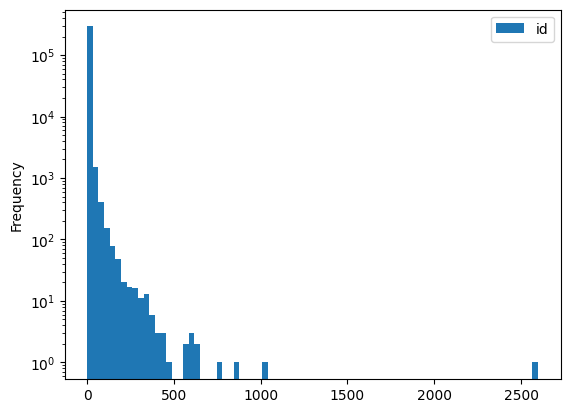

In [18]:
cpa.plot.hist(bins=80, logy=True)

Auch wenn die Verteilung etwas merkwürdig aussieht, passt das gut! Es gibt nur vier Autoren, die mehr als 1.000 Posts geschrieben haben. Das spricht für eine gut *balancierte* Community.

## Korrelationsanalyse

In Reddit können sog. *Scores* vergeben werden. Dahinter verbirgt sich die Differenz von Up- und Downvotes (die einzeln nicht mehr sichtbar sind). Du kannst nun die Hypothese aufstellen, dass Toplevel-Posts mit einem hohen Score auch viele (On-Topic-) Kommentare auf sich ziehen.

Zunächst bestimmst du die Anzahl der Kommentare pro Parent, indem du nach `parent_id` gruppierst:

In [19]:
cc = posts[["id", "parent_id"]].groupby("parent_id").count().rename(columns={"id": "comment_count"})

Nun verbindest du die beiden `DataFrame`s miteinander. Achtung, in dieser Version werden nur die Kommentare auf der ersten Ebene berücksichtigt!

<Axes: xlabel='score', ylabel='comment_count'>

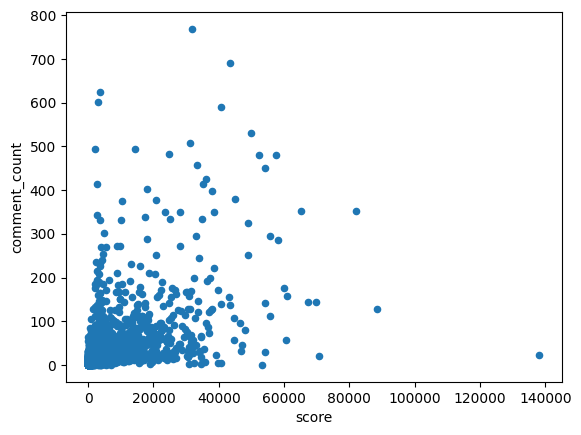

In [20]:
comments_and_score = top.merge(cc, left_on="id", right_index=True, how="left").\
                         fillna({"comment_count": 0})
comments_and_score.plot.scatter(x="score", y="comment_count")

Das sieht nach einem schwachen Zusammenhang aus. Wenn du das quantifizieren willst, führst du  eine Regressionsanalyse durch:

In [21]:
import scipy.stats
r = scipy.stats.linregress(comments_and_score["score"], comments_and_score["comment_count"])
r

LinregressResult(slope=0.0040843230410454075, intercept=0.7066557924116182, rvalue=0.6079995072280088, pvalue=0.0, stderr=1.689744850885692e-05, intercept_stderr=0.028837914524746253)

Der *Pearson R*-Wert ist 1, wenn Werte total korreliert sind, -1 bei einer Antikorrelation und 0 bei unkorrelierten Werten. Auch hier kann man die Korrelation gut erkennen. `p` ist das sog. Signifikanzniveau und hier sehr klein, was für die Güte der Analyse spricht.

Nachdem der Score in etwa den Likes in anderen sozialen Netzwerken entspricht, hast du hier den bekannten Zusammenhang zwischen Likes und Comments nachgewiesen.